In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d soumikrakshit/anime-faces

 99% 438M/441M [00:04<00:00, 107MB/s] 
100% 441M/441M [00:04<00:00, 94.3MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/anime-faces.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm.notebook import tqdm  #  tqdm is a Python library for adding progress bar

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, array_to_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

warnings.filterwarnings('ignore')

In [ ]:
BASE_DIR = '/content/data/data'

In [ ]:
# load complete image paths to the list
image_paths = []
for image_name in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, image_name)
    image_paths.append(image_path)

In [ ]:
len(image_paths)

21551

In [ ]:
# Next we will visualize few images in the dataset

# to display grid of images (7x7)
plt.figure(figsize=(20, 20))
temp_images = image_paths[:49]
index = 1

for image_path in temp_images:
    plt.subplot(7, 7, index)
    # load the image
    img = load_img(image_path)
    # convert to numpy array
    img = np.array(img)
    # show the image
    plt.imshow(img)
    plt.axis('off')
    # increment the index for next image
    index += 1

In [ ]:
# Next we will preprocess the dataset

# load the image and convert to numpy array
train_images = [np.array(load_img(path)) for path in tqdm(image_paths)]
train_images = np.array(train_images)

  0%|          | 0/21551 [00:00<?, ?it/s]

In [ ]:
train_images[0].shape

(64, 64, 3)

In [ ]:
# Next we will reshape the numpy array

# reshape the array
train_images = train_images.reshape(train_images.shape[0], 64, 64, 3).astype('float32')

In [ ]:
# normalize the images
train_images = (train_images - 127.5) / 127.5

In [ ]:
train_images[0]

array([[[-0.8039216 , -0.8117647 , -0.654902  ],
        [-0.7882353 , -0.8117647 , -0.64705884],
        [-0.73333335, -0.7490196 , -0.5764706 ],
        ...,
        [-0.11372549,  0.01176471,  0.27058825],
        [-0.01176471,  0.12941177,  0.4117647 ],
        [ 0.15294118,  0.33333334,  0.6784314 ]],

       [[-0.7647059 , -0.77254903, -0.60784316],
        [-0.7882353 , -0.8039216 , -0.6392157 ],
        [-0.7254902 , -0.7411765 , -0.5764706 ],
        ...,
        [-0.07450981,  0.06666667,  0.34117648],
        [ 0.08235294,  0.24705882,  0.58431375],
        [ 0.20784314,  0.41960785,  0.79607844]],

       [[-0.78039217, -0.79607844, -0.6313726 ],
        [-0.8039216 , -0.81960785, -0.654902  ],
        [-0.75686276, -0.77254903, -0.60784316],
        ...,
        [ 0.04313726,  0.21568628,  0.52156866],
        [ 0.1764706 ,  0.3647059 ,  0.7254902 ],
        [ 0.35686275,  0.5686275 ,  0.88235295]],

       ...,

       [[ 0.99215686,  0.8980392 ,  0.67058825],
        [ 0

In [ ]:
#First we will initialize the required values to the variables

# Latent Space is an abstract, lower-dimensional representation of high-dimensional data,
# often used in machine learning and data science to simplify complex data structures
# and reveal hidden patterns.

# latent dimension for random noise


LATENT_DIM = 100
# weight initializer
WEIGHT_INIT = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# no. of channels of the image
CHANNELS = 3 # for gray scale, keep it as 1

In [ ]:
# Generator Model will create new images similar to training data from random noise

model = Sequential(name='generator')

# 1d random noise
model.add(layers.Dense(8 * 8 * 512, input_dim=LATENT_DIM))
model.add(layers.ReLU())

# convert 1d to 3d
model.add(layers.Reshape((8, 8, 512)))

# upsample to 16x16
model.add(layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 32x32
model.add(layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

# upsample to 64x64
model.add(layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=WEIGHT_INIT))
model.add(layers.ReLU())

model.add(layers.Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh'))

generator = model
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 re_lu (ReLU)                (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 16, 16, 256)       2097408   
 anspose)                                                        
                                                                 
 re_lu_1 (ReLU)              (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 32, 32, 128)       524416    
 Transpose)                                              

In [ ]:
# Discriminator model will classify the image from the generator to check whether it real (or) fake images

model = Sequential(name='discriminator')
input_shape = (64, 64, 3)
alpha = 0.2

# create conv layers
model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', input_shape=input_shape))
model.add(layers.BatchNormalization())
model.add(layers.LeakyReLU(alpha=alpha))

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))

# output class
model.add(layers.Dense(1, activation='sigmoid'))

discriminator = model
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 batch_normalization (Batch  (None, 32, 32, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 16, 16, 128)       512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)     

In [ ]:
# Create DCGAN

class DCGAN(keras.Model):
    def __init__(self, generator, discriminator, latent_dim):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.latent_dim = latent_dim
        self.g_loss_metric = keras.metrics.Mean(name='g_loss')
        self.d_loss_metric = keras.metrics.Mean(name='d_loss')

    @property
    def metrics(self):
        return [self.g_loss_metric, self.d_loss_metric]

    def compile(self, g_optimizer, d_optimizer, loss_fn):
        super(DCGAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        # get batch size from the data
        batch_size = tf.shape(real_images)[0]
        # generate random noise
        random_noise = tf.random.normal(shape=(batch_size, self.latent_dim))

        # train the discriminator with real (1) and fake (0) images
        with tf.GradientTape() as tape:
            # compute loss on real images
            pred_real = self.discriminator(real_images, training=True)
            # generate real image labels
            real_labels = tf.ones((batch_size, 1))
            # label smoothing
            real_labels += 0.05 * tf.random.uniform(tf.shape(real_labels))
            d_loss_real = self.loss_fn(real_labels, pred_real)

            # compute loss on fake images
            fake_images = self.generator(random_noise)
            pred_fake = self.discriminator(fake_images, training=True)
            # generate fake labels
            fake_labels = tf.zeros((batch_size, 1))
            d_loss_fake = self.loss_fn(fake_labels, pred_fake)

            # total discriminator loss
            d_loss = (d_loss_real + d_loss_fake) / 2

        # compute discriminator gradients
        gradients = tape.gradient(d_loss, self.discriminator.trainable_variables)
        # update the gradients
        self.d_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))


        # train the generator model
        labels = tf.ones((batch_size, 1))
        # generator want discriminator to think that fake images are real
        with tf.GradientTape() as tape:
            # generate fake images from generator
            fake_images = self.generator(random_noise, training=True)
            # classify images as real or fake
            pred_fake = self.discriminator(fake_images, training=True)
            # compute loss
            g_loss = self.loss_fn(labels, pred_fake)

        # compute gradients
        gradients = tape.gradient(g_loss, self.generator.trainable_variables)
        # update the gradients
        self.g_optimizer.apply_gradients(zip(gradients, self.generator.trainable_variables))

        # update states for both models
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)

        return {'d_loss': self.d_loss_metric.result(), 'g_loss': self.g_loss_metric.result()}

In [ ]:
# Next we will plot some images for each epoch

class DCGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=25, latent_dim=100):
        self.num_imgs = num_imgs
        self.latent_dim = latent_dim
        # create random noise for generating images
        self.noise = tf.random.normal([25, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        # generate the image from noise
        g_img = self.model.generator(self.noise)
        # denormalize the image
        g_img = (g_img * 127.5) + 127.5
        g_img.numpy()

        fig = plt.figure(figsize=(8, 8))
        for i in range(self.num_imgs):
            plt.subplot(5, 5, i+1)
            img = array_to_img(g_img[i])
            plt.imshow(img)
            plt.axis('off')
        # plt.savefig('epoch_{:03d}.png'.format(epoch))
        plt.show()

    def on_train_end(self, logs=None):
        self.model.generator.save('generator.h5')

In [ ]:
# Now let us initialize the DCGAN model

dcgan = DCGAN(generator=generator, discriminator=discriminator, latent_dim=LATENT_DIM)

In [ ]:
# Next let us compile the DCGAN model

D_LR = 0.0001
G_LR = 0.0003
dcgan.compile(g_optimizer=Adam(learning_rate=G_LR, beta_1=0.5), d_optimizer=Adam(learning_rate=D_LR, beta_1=0.5), loss_fn=BinaryCrossentropy())

In [ ]:
# Next we will train the model

N_EPOCHS = 30
dcgan.fit(train_images, epochs=N_EPOCHS, callbacks=[DCGANMonitor()])

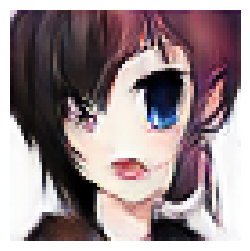

In [ ]:
noise = tf.random.normal([1, 100])
fig = plt.figure(figsize=(3, 3))
# generate the image from noise
g_img = dcgan.generator(noise)
# denormalize the image
g_img = (g_img * 127.5) + 127.5
g_img.numpy()
img = array_to_img(g_img[0])
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
from keras.models import load_model
# Save generator and discriminator models
dcgan.generator.save('generator_model.h5')
dcgan.discriminator.save('discriminator_model.h5')

# Load generator and discriminator models
loaded_generator = load_model('generator_model.h5')
loaded_discriminator = load_model('discriminator_model.h5')


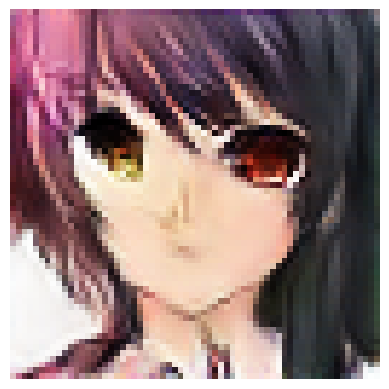

In [ ]:
# Testing the model
import tensorflow as tf
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import array_to_img

# Load the generator model
loaded_generator = load_model('generator.h5')

# Generate random noise
noise = tf.random.normal([1, 100])

# Generate an image from the noise using the loaded generator
generated_image = loaded_generator(noise)

# Denormalize the image
generated_image = (generated_image * 127.5) + 127.5

# Convert the image tensor to a NumPy array
generated_image = generated_image.numpy()

# Convert the array to an image and display it
img = array_to_img(generated_image[0])
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
# for pickling the model
from tensorflow.keras.models import load_model, save_model
import pickle

# Assuming dcgan is your DCGAN model with a generator
generator_model = dcgan.generator

# Save the generator model
save_model(generator_model, 'generator_model.h5')

# Load the generator model
loaded_generator = load_model('generator_model.h5')




# Serialize the generator model
with open('generator_model.pkl', 'wb') as f:
    pickle.dump(generator_model, f)

# Deserialize the generator model
with open('generator_model.pkl', 'rb') as f:
    loaded_generator = pickle.load(f)


In [ ]:
! pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 103.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import pickle

In [ ]:
# %%writefile app.py
# import streamlit as st
# import pickle
# import tensorflow as tf
# import numpy as np
# from PIL import Image

# def generate_faces(generator, num_images, randomness_level):
#     generated_images = []

#     for _ in range(num_images):
#         # Generate random noise
#         random_noise = np.random.normal(size=(1, 100))

#         # Adjust randomness based on user input
#         random_noise *= randomness_level

#         # Generate face using the loaded generator
#         generated_image = generator.predict(random_noise)[0]

#         # Denormalize the image
#         generated_image = (generated_image + 1) * 127.5

#         # Resize to 64x64
#         generated_image = tf.image.resize(generated_image, (16, 16)).numpy()

#         # Convert to PIL Image for display
#         pil_image = Image.fromarray(generated_image.astype('uint8'))

#         # Append the generated image to the list
#         generated_images.append(pil_image)

#     return generated_images

# def main():
#     st.title("Anime Face Generator")

#     # Load the generator model
#     with open('generator_model.pkl', 'rb') as f:
#         loaded_generator = pickle.load(f)

#     # Number of Images
#     num_images = st.slider("Number of Images", 1, 20, 5)

#     # Randomness Level
#     randomness_level = st.slider("Randomness Level", 0.0, 1.0, 0.5, step=0.1)

#     # Generate Faces Button
#     if st.button("Generate Faces"):
#         generated_images = generate_faces(loaded_generator, num_images, randomness_level)

#         # Calculate the number of rows and columns
#         num_columns = min(num_images, 5)
#         num_rows = (num_images + num_columns - 1) // num_columns

#         # Display the generated images in rows and columns
#         for row in range(num_rows):
#             row_images = generated_images[row * num_columns: (row + 1) * num_columns]
#             columns = st.columns(num_columns)

#             for img, col in zip(row_images, columns):
#                 col.image(img, caption=f"Generated Anime Face", width=16, use_column_width=True)

# if __name__ == '__main__':
#     main()


In [ ]:
%%writefile app.py
# %%writefile app.py
import streamlit as st
import pickle
import tensorflow as tf
import numpy as np
from PIL import Image
from io import BytesIO

def generate_faces(generator, num_images, randomness_level):
    generated_images = []

    for _ in range(num_images):
        # Generate random noise
        random_noise = np.random.normal(size=(1, 100))

        # Adjust randomness based on user input
        random_noise *= randomness_level

        # Generate face using the loaded generator
        generated_image = generator.predict(random_noise)[0]

        # Denormalize the image
        generated_image = (generated_image + 1) * 127.5

        # Resize to 20x20
        generated_image = tf.image.resize(generated_image, (20, 20)).numpy()

        # Convert to PIL Image for display
        pil_image = Image.fromarray(generated_image.astype('uint8'))

        # Append the generated image to the list
        generated_images.append(pil_image)

    return generated_images

def main():
    st.title("Anime Face Generator")

    # Load the generator model
    with open('generator_model.pkl', 'rb') as f:
        loaded_generator = pickle.load(f)

    # Number of Images
    num_images = st.slider("Number of Images", 1, 5, 2)

    # Randomness Level
    randomness_level = st.slider("Randomness Level", 0.0, 1.0, 0.5, step=0.1)

    # Show noise as the starting point
    starting_point_noise_images = []
    for _ in range(num_images):
        starting_point_noise = np.random.normal(size=(1, 100))
        starting_point_noise_image = np.clip((starting_point_noise + 1) * 127.5, 0, 255).astype('uint8')
        starting_point_pil_image = Image.fromarray(starting_point_noise_image[0], mode='L')  # Convert to grayscale
        resized_noise_image = starting_point_pil_image.resize((20, 20))
        starting_point_noise_images.append(resized_noise_image)

    # Display the noise images
    st.write("This is where we started")
    columns = st.columns(num_images)
    for i, (img, col) in enumerate(zip(starting_point_noise_images, columns)):
        # Display image
        col.image(img, caption=f"Noise Image {i + 1}", width=20, use_column_width=True)



    # Generate Faces Button
    if st.button("Generate Faces"):
        generated_images = generate_faces(loaded_generator, num_images, randomness_level)

        # Title for generated images
        st.write("This is where our model takes us")

        # Calculate the number of rows and columns
        num_columns = min(num_images, 5)
        num_rows = (num_images + num_columns - 1) // num_columns

        # Display the generated images in rows and columns
        for row in range(num_rows):
            row_images = generated_images[row * num_columns: (row + 1) * num_columns]
            columns = st.columns(num_columns)

            for i, (img, col) in enumerate(zip(row_images, columns)):
                # Display image
                col.image(img, caption=f"Generated Anime Face {i + 1}", width=20, use_column_width=True)

                # Download button
                img_bytes = BytesIO()
                img.save(img_bytes, format='PNG')
                col.download_button(label=f"Download Image {i + 1}", data=img_bytes, file_name=f"generated_image_{i + 1}.png", mime='image/png')

if __name__ == '__main__':
    main()



Overwriting app.py


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.192.34.227


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501

[..................] \ fetchMetadata: sill resolveWithNewModule yargs@17.1.1 ch


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://35.192.34.227:8501

npx: installed 22 in 2.429s
your url is: https://fluffy-socks-film.loca.lt
2023-11-17 20:07:34.648096: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 20:07:34.648148: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 20:07:34.648181: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 20:07:35.634064: W tensorflow/compiler/tf2tensorrt/utils